✅ Dataset cargado correctamente con 51,696 registros totales (vuelos de llegada y salida).
🧹 Registros válidos luego de limpieza: 49,851 vuelos.

📊 Resultados comparativos:


,Modelo,MAE,RMSE,R²,Interpretabilidad,Costo Computacional
0,Regresión Lineal,7.750881,10.486084,-0.105923,Alta,Bajo
1,ARIMA,7.705528,10.563906,-0.122399,Media,Medio
2,LSTM,5.405286,9.394451,0.119701,Media-Baja,Alto



🧮 Matriz de Confusión:


,Predicho Puntual,Predicho Impuntual,Total
Real Puntual,86,135,221
Real Impuntual,6,212,218
Total,92,347,439



📈 Métricas Derivadas:


,Métrica,Valor
0,Precisión Global (Accuracy),0.678815
1,Sensibilidad (Recall Puntualidad),0.972477
2,Especificidad (Recall Impuntualidad),0.972477
3,F1-score,0.750442


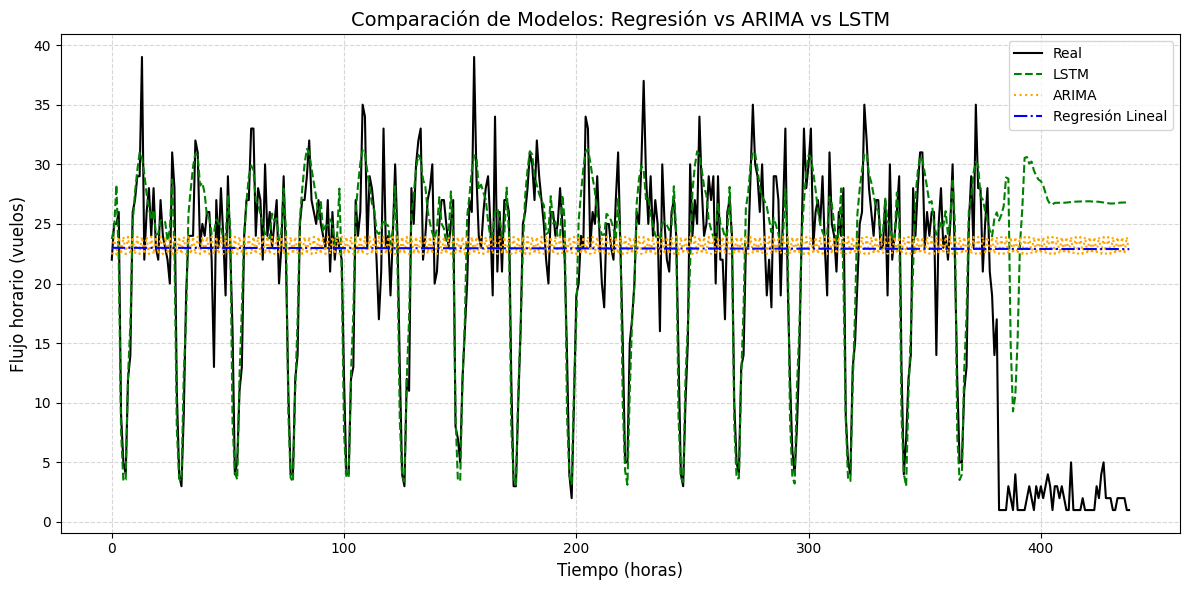

❌ Error al exportar el archivo: No module named 'xlsxwriter'
✅ Modelos guardados correctamente.


In [2]:
# ============================================
# 1️⃣ Importar librerías necesarias
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    confusion_matrix, accuracy_score, recall_score, f1_score
)
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
import joblib
import warnings
warnings.filterwarnings("ignore")

# ============================================
# 2️⃣ Cargar Dataset
# ============================================
url = "https://raw.githubusercontent.com/anterotello/IA/main/data/raw/Dataset%20-%20Flujo%20horario.xlsx"
df = pd.read_excel(url)
print(f"✅ Dataset cargado correctamente con {len(df):,} registros totales (vuelos de llegada y salida).")

# ============================================
# 3️⃣ Limpieza y preparación de datos
# ============================================
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df = df.drop_duplicates()

# Conversión de fechas y horas
for col in ['ETA', 'ETD']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Eliminar filas sin ETA ni ETD
df = df.dropna(subset=['ETA', 'ETD'], how='all')

# Variables temporales
df['hour'] = df['ETA'].dt.hour.fillna(df['ETD'].dt.hour)
df['weekday'] = df['ETA'].dt.dayofweek.fillna(df['ETD'].dt.dayofweek)
df['month'] = df['ETA'].dt.month.fillna(df['ETD'].dt.month)

# Variables cíclicas
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

print(f"🧹 Registros válidos luego de limpieza: {len(df):,} vuelos.")

# ============================================
# 4️⃣ Crear flujo horario agregado
# ============================================
df['hour_slot'] = df['ETA'].dt.floor('h').fillna(df['ETD'].dt.floor('h'))
fbh = df.groupby('hour_slot').size().reset_index(name='flight_count_hourly')

# ============================================
# 5️⃣ Escalado y preparación del modelo
# ============================================
scaler = StandardScaler()
fbh['scaled_flow'] = scaler.fit_transform(fbh[['flight_count_hourly']])

# Ventana temporal para LSTM
window = 24
X, y = [], []
for i in range(len(fbh) - window):
    X.append(fbh['scaled_flow'].iloc[i:i+window].values)
    y.append(fbh['scaled_flow'].iloc[i+window])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# División train-test
train_size = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# ============================================
# 6️⃣ Modelo LSTM
# ============================================
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(window, 1)),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.1, verbose=0)

# Predicción LSTM
y_pred_lstm = model.predict(X_test, verbose=0)
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# ============================================
# 7️⃣ Modelo ARIMA
# ============================================
train_arima = fbh['flight_count_hourly'][:int(len(fbh)*0.8)]
test_arima = fbh['flight_count_hourly'][int(len(fbh)*0.8):]

model_arima = ARIMA(train_arima, order=(3, 1, 2))
arima_fit = model_arima.fit()
pred_arima = arima_fit.forecast(steps=len(test_arima))

# ============================================
# 8️⃣ Modelo de Regresión Lineal
# ============================================
fbh['hour_num'] = np.arange(len(fbh))
train_lin = fbh.iloc[:int(len(fbh)*0.8)]
test_lin = fbh.iloc[int(len(fbh)*0.8):]

X_train_lin = train_lin[['hour_num']]
X_test_lin = test_lin[['hour_num']]
y_train_lin = train_lin['flight_count_hourly']
y_test_lin = test_lin['flight_count_hourly']

lin_model = LinearRegression()
lin_model.fit(X_train_lin, y_train_lin)
pred_lin = lin_model.predict(X_test_lin)

# ============================================
# 9️⃣ Evaluación de desempeño (MAE, RMSE, R²)
# ============================================
def eval_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

mae_lstm, rmse_lstm, r2_lstm = eval_metrics(y_test_inv, y_pred_lstm_inv)
mae_arima, rmse_arima, r2_arima = eval_metrics(test_arima, pred_arima)
mae_lin, rmse_lin, r2_lin = eval_metrics(y_test_lin, pred_lin)

results = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'ARIMA', 'LSTM'],
    'MAE': [mae_lin, mae_arima, mae_lstm],
    'RMSE': [rmse_lin, rmse_arima, rmse_lstm],
    'R²': [r2_lin, r2_arima, r2_lstm],
    'Interpretabilidad': ['Alta', 'Media', 'Media-Baja'],
    'Costo Computacional': ['Bajo', 'Medio', 'Alto']
})

print("\n📊 Resultados comparativos:")
display(results)

# ============================================
# 🔟 Matriz de Confusión (Puntual / Impuntual)
# ============================================
threshold = np.median(y_test_inv)
y_true_class = (y_test_inv > threshold).astype(int)
y_pred_class = (y_pred_lstm_inv > threshold).astype(int)

cm = confusion_matrix(y_true_class, y_pred_class)
cm_df = pd.DataFrame(cm, index=['Real Puntual', 'Real Impuntual'],
                     columns=['Predicho Puntual', 'Predicho Impuntual'])
cm_df.loc['Total'] = cm_df.sum()
cm_df.loc[:, 'Total'] = cm_df.sum(axis=1)

print("\n🧮 Matriz de Confusión:")
display(cm_df)

# ============================================
# 11️⃣ Métricas derivadas (Precision, Recall, F1)
# ============================================
accuracy = accuracy_score(y_true_class, y_pred_class)
recall_puntual = recall_score(y_true_class, y_pred_class)  # sensibilidad
recall_impuntual = cm[1,1] / (cm[1,0] + cm[1,1]) if (cm[1,0]+cm[1,1]) > 0 else np.nan
f1 = f1_score(y_true_class, y_pred_class)

metrics_derived = pd.DataFrame({
    'Métrica': ['Precisión Global (Accuracy)', 'Sensibilidad (Recall Puntualidad)',
                'Especificidad (Recall Impuntualidad)', 'F1-score'],
    'Valor': [accuracy, recall_puntual, recall_impuntual, f1]
})

print("\n📈 Métricas Derivadas:")
display(metrics_derived)

# ============================================
# 12️⃣ Visualización comparativa
# ============================================
plt.figure(figsize=(12, 6))
min_len = min(len(y_test_inv), len(pred_arima), len(pred_lin))
plt.plot(y_test_inv[-min_len:], label='Real', color='black', linewidth=1.5)
plt.plot(y_pred_lstm_inv[-min_len:], label='LSTM', color='green', linestyle='--')
plt.plot(pred_arima.values[-min_len:], label='ARIMA', color='orange', linestyle='dotted')
plt.plot(pred_lin[-min_len:], label='Regresión Lineal', color='blue', linestyle='dashdot')
plt.title("Comparación de Modelos: Regresión vs ARIMA vs LSTM", fontsize=14)
plt.xlabel("Tiempo (horas)", fontsize=12)
plt.ylabel("Flujo horario (vuelos)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ============================================
# 13️⃣ Exportar data y resultados a Excel
# ============================================
output_file = "data_limpia_transformada_resultados.xlsx"
try:
    with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
        df.to_excel(writer, sheet_name='Data_Limpia', index=False)
        fbh.to_excel(writer, sheet_name='Flujo_Horario', index=False)
        results.to_excel(writer, sheet_name='Resultados_Modelos', index=False)
        cm_df.to_excel(writer, sheet_name='Matriz_Confusión')
        metrics_derived.to_excel(writer, sheet_name='Métricas_Derivadas', index=False)
    print(f"✅ Archivo Excel exportado exitosamente en: {output_file}")
except Exception as e:
    print(f"❌ Error al exportar el archivo: {e}")

# ============================================
# 14️⃣ Guardar modelos y escaladores
# ============================================
model.save("lstm_flow_model_final.keras")
joblib.dump(scaler, "scaler.save")
arima_fit.save("arima_flow_model.pkl")
joblib.dump(lin_model, "linear_regression_model.pkl")

print("✅ Modelos guardados correctamente.")
